# Watershed Model

## Model Description 
This is a 3 layered model with no flow boundaries on three sides.
A dowgradient boundary with a constant head of 70m.

#### Dimensions: 
- 50 by 50 cells
- dx = dy = 1000 m
- dz bottom layer = 45 m
- dz middle layer = 5m
- dz top layer = depends on topography

#### Topography
- Land surface is non linear and differs along the domain.

#### Subsurface Properties: 
- All layers are Homogeneous 
- K Top Layer = 8.5 m/day in x and y and 8.5 m/day in z.  
- K Bottom Layer = 8.5 m/day in x and y and 8.5 m/day in z.
- K Middle Layer = 8.5 m/day in x and y and 8.5 m/day in z. [12 leftmost colums]
- K Middle Layer = 8.5 m/day in x and y and 1E-4 m/day in z. [remaining colums]
- Porosity = 0.1
- Specific yield = 0.1
- Storage coefficient=0.0001  

#### Boundary Conditions: 
 - Left boundary no flow 
 - Top boundary no flow
 - Bottom boundary no flow
 - Right boundary is a constant head of 70m 
 - Recharge occurs at a rate of 4E-5 m/d in the leftmost 15 columns and zero elsewhere
 
#### Well: 
 - Town Pumping well
     - Located at (38000, 21000)x,y
     - Pumping at a rate of 1500 m^3/day 
 - Agriculture Pumping well
     - Located at (14000, 12000)x,y
     - Pumping at a rate of 6000 m^3/day 

     

## 1. Setup the environment

In [1]:
#the basics
import flopy
import numpy as np
import matplotlib as mp
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

#jupyter specific--included to show plots in notebook
%matplotlib inline 



## 2. Setup the input variables 

In [2]:
## model directory
moddir="C:/Users/starl/GW_Modelling/homework-starliviakaska/mf2005"

## Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers
dx= 1000 #width of grid cells in x direction 
dy= 1000 #width of grid cells in y direction 
Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

myList=[]

with open('BASE_top_elev.csv', 'r', encoding='utf-8-sig') as reader:
    ztop = np.genfromtxt(reader, dtype=float, delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow,ncol)
    
zbot = 0.     #bottom elevation
dz = (ztop - zbot) / nlay #cell height in z direction


## Timing
nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type


## Subsurface properties
K_horiz = 8.5    #assign horizontal hydraulic conductivity 
K_vert = 8.5    #assign vertical hydraulic conductivity (along z axis)
Kz_other = 0.0001
n = 0.1        #assign porosity
Ss = 0.0001      #assign storage coefficient
Sy = 0.1        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined


## Recharge
recharge = 4e-5 #m/day
ag_recharge =0.0012

##ET
bkgndET = 1e-5  #set background ET value m/day
riparian = 5e-4


##Town Well
Q_in_town = -1500                       # Volumetric flux from the well in units of L3/T 
fluxes_town = [2,21,38,Q_in_town]

##AG Well
Q_in_ag = -6000                       # Volumetric flux from the well in units of L3/T 
fluxes_ag = [0,12,14,Q_in_ag]

##Boundary conditions
h_right = 70


##Stream
stage = 0.5
slope = 0.001  #slope of streambed (m/m)
rough = 0.04 #roughness of streambed
width = 1. #x-sectional width of channel (m)
Flow_into_the_1st_reach = 0 # m^3/day
set_icalc = 1  # the stage is to be calculated based on flow
const = 86400.0 #multiplication constant for m3/day 
k_strbott = 10  #river bottom hydraulic conductivity in l/t
sed_thick = 1 #thickness of riverbed sediment 
cond = k_strbott*(width)*(dy)/(sed_thick) 
nreach =  50   # river extending the width of the domain
return_loc = 25    #specifying the column where the town return flows come in
nseg=3
Qreturn =50     # return flow from the town
noReturn= 0     
ntrib=0

## 3. Setup and run MODFLOW for NTNA

In [3]:
#Initialize the model
modelname1 = "NTNA"
m1 = flopy.modflow.Modflow(modelname1, exe_name = moddir)

## Make some changes to the parameters
botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[1,:,:] = 40.                  # bottom elevation of middle layer (1) is 25 m
botm[0,:,:] = 45.                  # bottom elevation of top layer (0) is 35 m 

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[0:,:,:] = K_vert                   # assign the original value to the entire top layer
Kz[1,:,:] = K_vert                   # assign the origional value to the entire middle layer
Kz[2,:,:]= K_vert                    #assign the origional value to the entire bottom layer
Kz[1,:,19:49]= Kz_other              # assign the low K inclusion in the right portion of the middle layer

Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[0:,:,:] = K_horiz                  # assign the original value to the entire top layer
Kh[1:,:,:] = K_horiz                   # assign the original value to the entire middle layer
Kh[2:,:,:] = K_horiz                   # assign the original value to the entire bottom layer

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m1, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)


# Boundary and initial conditions - bas
#Define cell activity (IBOUND)
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
ibound[:,0,:] = 0          #replace top-most column (all zs, all ys, first x) with 0 to indicate a no flow boundary
ibound[:,49,:] = 0         #replace bottom-most row (all zs, all ys, first x) with 0 to indicate a no flow boundary
ibound[:,:,0]=0           #replace leftmost column (all zs, all ys, first x) with 0 to indicate a no flow boundary
ibound[:,:,49] = -1        #replace rightmost column (all zs, all ys, first x) with -1 to indicate constant head

for i in range (0,6):
    ibound[0:, i, 0:6-i] = 0
for i in range (0,8):
    ibound[1, i, 0:8-i] = 0
for i in range (0,10):
    ibound[2, i, 0:10-i] = 0
for i in range (0,6):
    ibound[0:, 44+i, 0:1+i] = 0
for i in range (0,8):
    ibound[1, 42+i, 0:1+i] = 0
for i in range (0,10):
    ibound[2, 40+i, 0:1+1] = 0

#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right    #initialize the entire domain to the right head value

bas = flopy.modflow.ModflowBas(m1, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m1, laytyp=uncnf, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 

#Recharge 
rech_zone = np.zeros((nrow,ncol))               #define an array of zeros of dim (nrow,ncol)
rech_zone=rech_zone+recharge
rech_zone[:,15:50]=0
rch = flopy.modflow.mfrch.ModflowRch(model=m1, rech=rech_zone, ipakcb=53)     #create rch object

#ET
ET_zone = np.zeros((nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0:49,25:49]= bkgndET                            # set ET in the right half of the domain
ET_zone[22:28,:] = riparian            #apply ET to the riparian area
extinction_depth = 1              #extinction depth is the depth where if our water table is below that, our ET will be ZERO
evt = flopy.modflow.mfevt.ModflowEvt(model=m1, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53)

#Str
str_rows = 25*np.ones((nreach),dtype=np.int32)  # integer array of row #s for each reach 
str_cols = np.arange(0,nreach)  # integer array of col #s for each reach 

      #Setup the inflows for the reaches
reach_flow = np.zeros((nreach),dtype=np.int32)  # initially set all inflows to zero for all reaches
reach_flow[return_loc] = noReturn # inflow to seg2 = return from town
reach_flow[return_loc+1] = -1 # inflow to seg3 = sum of all previous segs

         #setup segment numbers – this is a list of segment values that goes with each reach
segments = np.ones((nreach),dtype=np.int32)    # make a segment array that is nreach long and initialize all the values to 1
segments[return_loc] = 2    #Change the segment number to ‘2’ where the town recharge comes in
segments[return_loc+1:nreach] = 3    # Change the segment number to ‘3’ everywhere downstream of the the town well

     #setup reach numbers – this will be the numbering of the reaches within each segment. 
    # Recall that numbering starts and one and increases moving downstream
reaches = np.arange(1,nreach+1)   # create an array of reach #s counting from 1-50
reaches[return_loc] = 1    # reassign the reach number to be 1 for segment 2
reaches[return_loc+1:nreach] = np.arange(1,nreach-(return_loc+1)+1)  # reassign the reach numbers for segment 3 to start counting at 1
surf_elev = np.zeros((nreach))   # create array of zeros the length of the stream

    # loop over the stream reaches and pull the land surface elevation for the location of each stream cell
for i in np.arange(nreach): 
      surf_elev[i] = ztop[str_rows[i],str_cols[i]]
Stop = surf_elev -  1.    # elevation of the top of the streambed (1 m below land surface) (m)
Sbot = Stop - sed_thick      # elevation of the bottom of the streambed (m)
stage_elev = Stop + stage      # elevation of the water surface in the stream (m)

    #Stress Period Dictionary
str_info = np.zeros((nreach,13)) # create array of zeros for reaches, each reach requires 13 input values

     # Loop over the reaches and setup the data
for r in np.arange(nreach): 
     str_info[r,:] = [0, str_rows[r], str_cols[r], segments[r], reaches[r], reach_flow[r], stage_elev[r], k_strbott, Sbot[r], Stop[r],    		width,  slope, rough]
str_spd = {0: str_info} # save the stream info in a stress period dictionary

    #Segments Dictionary
    #for each segment, need an array of 10 zeros, for last segment, first two values are seg #s of upstream segments
seg_info = np.zeros((10,nseg))
seg_info = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
str_segd = {0: seg_info}  #save the stream info in a segment dictionary
strm = flopy.modflow.mfstr.ModflowStr(m1, mxacts=nreach, nss=nseg, ntrib=ntrib, ndiv=0,icalc=set_icalc, const=const, ipakcb=53, istcb2=53, dtype=None, stress_period_data=str_spd, segment_data=str_segd, extension='str')


#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m1, stress_period_data=spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m1)

#write the inputs
m1.write_input()    

#Run the model 
success, mfoutput = m1.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following executable to run the model: C:/Users/starl/GW_Modelling/homework-starliviakaska/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: NTNA.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/04/21 23:53:19

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/04/21 23:53:19
 Elapsed run time:  0.098 Seconds

  Normal termination of simulation


## 4. Setup and run MODFLOW for YTNA

In [4]:
#Initialize the model
modelname2 = "YTNA"
m2 = flopy.modflow.Modflow(modelname2, exe_name = moddir)

## Make some changes to the parameters
botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[1,:,:] = 40.                  # bottom elevation of middle layer (1) is 25 m
botm[0,:,:] = 45.                  # bottom elevation of top layer (0) is 35 m 

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[0:,:,:] = K_vert                   # assign the original value to the entire top layer
Kz[1,:,:] = K_vert                   # assign the origional value to the entire middle layer
Kz[2,:,:]= K_vert                    #assign the origional value to the entire bottom layer
Kz[1,:,19:49]= Kz_other              # assign the low K inclusion in the right portion of the middle layer

Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[0:,:,:] = K_horiz                  # assign the original value to the entire top layer
Kh[1:,:,:] = K_horiz                   # assign the original value to the entire middle layer
Kh[2:,:,:] = K_horiz                   # assign the original value to the entire bottom layer

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m2, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)


# Boundary and initial conditions - bas
#Define cell activity (IBOUND)
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
ibound[:,0,:] = 0          #replace top-most column (all zs, all ys, first x) with 0 to indicate a no flow boundary
ibound[:,49,:] = 0         #replace bottom-most row (all zs, all ys, first x) with 0 to indicate a no flow boundary
ibound[:,:,0]=0           #replace leftmost column (all zs, all ys, first x) with 0 to indicate a no flow boundary
ibound[:,:,49] = -1        #replace rightmost column (all zs, all ys, first x) with -1 to indicate constant head

for i in range (0,6):
    ibound[0:, i, 0:6-i] = 0
for i in range (0,8):
    ibound[1, i, 0:8-i] = 0
for i in range (0,10):
    ibound[2, i, 0:10-i] = 0
for i in range (0,6):
    ibound[0:, 44+i, 0:1+i] = 0
for i in range (0,8):
    ibound[1, 42+i, 0:1+i] = 0
for i in range (0,10):
    ibound[2, 40+i, 0:1+1] = 0

#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right    #initialize the entire domain to the right head value

bas = flopy.modflow.ModflowBas(m2, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m2, laytyp=uncnf, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 

#Recharge 
rech_zone = np.zeros((nrow,ncol))               #define an array of zeros of dim (nrow,ncol)
rech_zone=rech_zone+recharge
rech_zone[:,15:50]=0
rch = flopy.modflow.mfrch.ModflowRch(model=m2, rech=rech_zone, ipakcb=53)     #create rch object

#ET
ET_zone = np.zeros((nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0:49,25:49]= bkgndET                            # set ET in the right half of the domain
ET_zone[22:28,:] = riparian            #apply ET to the riparian area
extinction_depth = 1              #extinction depth is the depth where if our water table is below that, our ET will be ZERO
evt = flopy.modflow.mfevt.ModflowEvt(model=m2, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53)

#Str
str_rows = 25*np.ones((nreach),dtype=np.int32)  # integer array of row #s for each reach 
str_cols = np.arange(0,nreach)  # integer array of col #s for each reach 

      #Setup the inflows for the reaches
reach_flow = np.zeros((nreach),dtype=np.int32)  # initially set all inflows to zero for all reaches
reach_flow[return_loc] = Qreturn # inflow to seg2 = return from town
reach_flow[return_loc+1] = -1 # inflow to seg3 = sum of all previous segs

         #setup segment numbers – this is a list of segment values that goes with each reach
segments = np.ones((nreach),dtype=np.int32)    # make a segment array that is nreach long and initialize all the values to 1
segments[return_loc] = 2    #Change the segment number to ‘2’ where the town recharge comes in
segments[return_loc+1:nreach] = 3    # Change the segment number to ‘3’ everywhere downstream of the the town well

     #setup reach numbers – this will be the numbering of the reaches within each segment. 
    # Recall that numbering starts and one and increases moving downstream
reaches = np.arange(1,nreach+1)   # create an array of reach #s counting from 1-50
reaches[return_loc] = 1    # reassign the reach number to be 1 for segment 2
reaches[return_loc+1:nreach] = np.arange(1,nreach-(return_loc+1)+1)  # reassign the reach numbers for segment 3 to start counting at 1
surf_elev = np.zeros((nreach))   # create array of zeros the length of the stream

    # loop over the stream reaches and pull the land surface elevation for the location of each stream cell
for i in np.arange(nreach): 
      surf_elev[i] = ztop[str_rows[i],str_cols[i]]
Stop = surf_elev -  1.    # elevation of the top of the streambed (1 m below land surface) (m)
Sbot = Stop - sed_thick      # elevation of the bottom of the streambed (m)
stage_elev = Stop + stage      # elevation of the water surface in the stream (m)

    #Stress Period Dictionary
str_info = np.zeros((nreach,13)) # create array of zeros for reaches, each reach requires 13 input values

     # Loop over the reaches and setup the data
for r in np.arange(nreach): 
     str_info[r,:] = [0, str_rows[r], str_cols[r], segments[r], reaches[r], reach_flow[r], stage_elev[r], k_strbott, Sbot[r], Stop[r],    		width,  slope, rough]
str_spd = {0: str_info} # save the stream info in a stress period dictionary

    #Segments Dictionary
    #for each segment, need an array of 10 zeros, for last segment, first two values are seg #s of upstream segments
seg_info = np.zeros((10,nseg))
seg_info = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
str_segd = {0: seg_info}  #save the stream info in a segment dictionary
strm = flopy.modflow.mfstr.ModflowStr(m2, mxacts=nreach, nss=nseg, ntrib=ntrib, ndiv=0,icalc=set_icalc, const=const, ipakcb=53, istcb2=53, dtype=None, stress_period_data=str_spd, segment_data=str_segd, extension='str')

#Well
sp_fluxes = {0: fluxes_town}              #create a dictionary with entries for each stress period
wel = flopy.modflow.ModflowWel(model=m2, stress_period_data=sp_fluxes)

#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m2, stress_period_data=spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m2)

#write the inputs
m2.write_input()    

#Run the model 
success, mfoutput = m2.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following executable to run the model: C:/Users/starl/GW_Modelling/homework-starliviakaska/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: YTNA.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/04/21 23:53:20

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/04/21 23:53:20
 Elapsed run time:  0.126 Seconds

  Normal termination of simulation


## 5. Setup and run MODFLOW for YTYA

In [5]:
#Initialize the model
modelname3 = "YTYA"
m3 = flopy.modflow.Modflow(modelname3, exe_name = moddir)

## Make some changes to the parameters
botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[1,:,:] = 40.                  # bottom elevation of middle layer (1) is 25 m
botm[0,:,:] = 45.                  # bottom elevation of top layer (0) is 35 m 

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[0:,:,:] = K_vert                   # assign the original value to the entire top layer
Kz[1,:,:] = K_vert                   # assign the origional value to the entire middle layer
Kz[2,:,:]= K_vert                    #assign the origional value to the entire bottom layer
Kz[1,:,19:49]= Kz_other              # assign the low K inclusion in the right portion of the middle layer

Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[0:,:,:] = K_horiz                  # assign the original value to the entire top layer
Kh[1:,:,:] = K_horiz                   # assign the original value to the entire middle layer
Kh[2:,:,:] = K_horiz                   # assign the original value to the entire bottom layer

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m3, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)


# Boundary and initial conditions - bas
#Define cell activity (IBOUND)
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
ibound[:,0,:] = 0          #replace top-most column (all zs, all ys, first x) with 0 to indicate a no flow boundary
ibound[:,49,:] = 0         #replace bottom-most row (all zs, all ys, first x) with 0 to indicate a no flow boundary
ibound[:,:,0]=0           #replace leftmost column (all zs, all ys, first x) with 0 to indicate a no flow boundary
ibound[:,:,49] = -1        #replace rightmost column (all zs, all ys, first x) with -1 to indicate constant head

for i in range (0,6):
    ibound[0:, i, 0:6-i] = 0
for i in range (0,8):
    ibound[1, i, 0:8-i] = 0
for i in range (0,10):
    ibound[2, i, 0:10-i] = 0
for i in range (0,6):
    ibound[0:, 44+i, 0:1+i] = 0
for i in range (0,8):
    ibound[1, 42+i, 0:1+i] = 0
for i in range (0,10):
    ibound[2, 40+i, 0:1+1] = 0

#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right    #initialize the entire domain to the right head value

bas = flopy.modflow.ModflowBas(m3, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m3, laytyp=uncnf, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 

#Recharge 
rech_zone = np.zeros((nrow,ncol))               #define an array of zeros of dim (nrow,ncol)
rech_zone=rech_zone+recharge
rech_zone[:,15:50]=0
rech_zone[21:23,19:21] = ag_recharge
rch = flopy.modflow.mfrch.ModflowRch(model=m3, rech=rech_zone, ipakcb=53)     #create rch object

#ET
ET_zone = np.zeros((nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0:49,25:49]= bkgndET                            # set ET in the right half of the domain
ET_zone[22:28,:] = riparian            #apply ET to the riparian area
ET_zone[21:23,19:21] = 0               #ET on the ag plot
extinction_depth = 1              #extinction depth is the depth where if our water table is below that, our ET will be ZERO
evt = flopy.modflow.mfevt.ModflowEvt(model=m3, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53)

#Str
str_rows = 25*np.ones((nreach),dtype=np.int32)  # integer array of row #s for each reach 
str_cols = np.arange(0,nreach)  # integer array of col #s for each reach 

      #Setup the inflows for the reaches
reach_flow = np.zeros((nreach),dtype=np.int32)  # initially set all inflows to zero for all reaches
reach_flow[return_loc] = Qreturn # inflow to seg2 = return from town
reach_flow[return_loc+1] = -1 # inflow to seg3 = sum of all previous segs

         #setup segment numbers – this is a list of segment values that goes with each reach
segments = np.ones((nreach),dtype=np.int32)    # make a segment array that is nreach long and initialize all the values to 1
segments[return_loc] = 2    #Change the segment number to ‘2’ where the town recharge comes in
segments[return_loc+1:nreach] = 3    # Change the segment number to ‘3’ everywhere downstream of the the town well

     #setup reach numbers – this will be the numbering of the reaches within each segment. 
    # Recall that numbering starts and one and increases moving downstream
reaches = np.arange(1,nreach+1)   # create an array of reach #s counting from 1-50
reaches[return_loc] = 1    # reassign the reach number to be 1 for segment 2
reaches[return_loc+1:nreach] = np.arange(1,nreach-(return_loc+1)+1)  # reassign the reach numbers for segment 3 to start counting at 1
surf_elev = np.zeros((nreach))   # create array of zeros the length of the stream

    # loop over the stream reaches and pull the land surface elevation for the location of each stream cell
for i in np.arange(nreach): 
      surf_elev[i] = ztop[str_rows[i],str_cols[i]]
Stop = surf_elev -  1.    # elevation of the top of the streambed (1 m below land surface) (m)
Sbot = Stop - sed_thick      # elevation of the bottom of the streambed (m)
stage_elev = Stop + stage      # elevation of the water surface in the stream (m)

    #Stress Period Dictionary
str_info = np.zeros((nreach,13)) # create array of zeros for reaches, each reach requires 13 input values

     # Loop over the reaches and setup the data
for r in np.arange(nreach): 
     str_info[r,:] = [0, str_rows[r], str_cols[r], segments[r], reaches[r], reach_flow[r], stage_elev[r], k_strbott, Sbot[r], Stop[r],    		width,  slope, rough]
str_spd = {0: str_info} # save the stream info in a stress period dictionary

    #Segments Dictionary
    #for each segment, need an array of 10 zeros, for last segment, first two values are seg #s of upstream segments
seg_info = np.zeros((10,nseg))
seg_info = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
str_segd = {0: seg_info}  #save the stream info in a segment dictionary
strm = flopy.modflow.mfstr.ModflowStr(m3, mxacts=nreach, nss=nseg, ntrib=ntrib, ndiv=0,icalc=set_icalc, const=const, ipakcb=53, istcb2=53, dtype=None, stress_period_data=str_spd, segment_data=str_segd, extension='str')

#Well
sp_fluxes = {0: fluxes_ag, 0:fluxes_town}
wel = flopy.modflow.ModflowWel(model=m3, stress_period_data=sp_fluxes)

#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m3, stress_period_data=spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m3)

#write the inputs
m3.write_input()    

#Run the model 
success, mfoutput = m3.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following executable to run the model: C:/Users/starl/GW_Modelling/homework-starliviakaska/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: YTYA.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/04/21 23:53:20

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/04/21 23:53:20
 Elapsed run time:  0.144 Seconds

  Normal termination of simulation


# 5. Plot the domains
### 5.1 Plan view of the domain

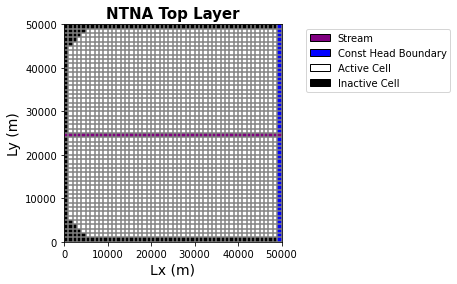

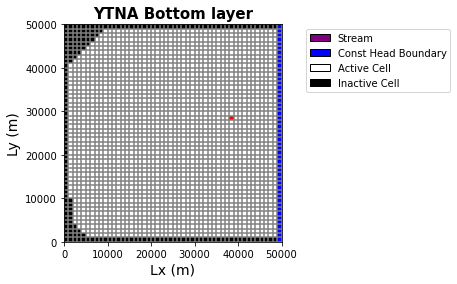

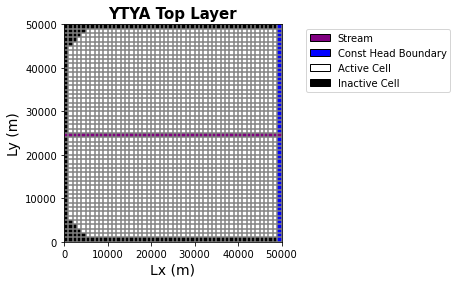

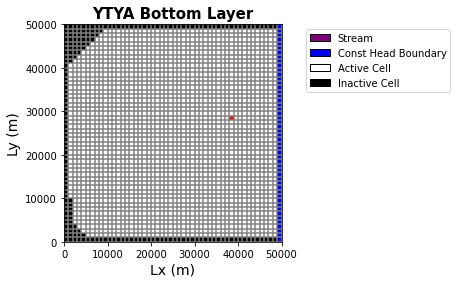

In [6]:
modelmap = flopy.plot.PlotMapView(model=m1, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('NTNA Top Layer', fontsize = 15, fontweight = 'bold')
str_m = modelmap.plot_bc("STR")
plt.legend(handles=[mp.patches.Patch(color='purple',label='Stream',ec='black'),
                   mp.patches.Patch(color='blue',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.8,1.0))
plt.show(modelmap)

modelmap = flopy.plot.PlotMapView(model=m2, layer=2)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('YTNA Bottom layer', fontsize = 15, fontweight = 'bold')
wel_m = modelmap.plot_bc("WEL")
str_m = modelmap.plot_bc("STR")
plt.legend(handles=[mp.patches.Patch(color='purple',label='Stream',ec='black'),
                   mp.patches.Patch(color='blue',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.8,1.0))
plt.show(modelmap)

modelmap = flopy.plot.PlotMapView(model=m3, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('YTYA Top Layer', fontsize = 15, fontweight = 'bold')
wel_m = modelmap.plot_bc("WEL")
str_m = modelmap.plot_bc("STR")
plt.legend(handles=[mp.patches.Patch(color='purple',label='Stream',ec='black'),
                   mp.patches.Patch(color='blue',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.8,1.0))
plt.show(modelmap)

modelmap = flopy.plot.PlotMapView(model=m3, layer=2)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('YTYA Bottom Layer', fontsize = 15, fontweight = 'bold')
wel_m = modelmap.plot_bc("WEL")
str_m = modelmap.plot_bc("STR")
plt.legend(handles=[mp.patches.Patch(color='purple',label='Stream',ec='black'),
                   mp.patches.Patch(color='blue',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.8,1.0))
plt.show(modelmap)

The plots above show you the model grid and the location of the wells in each layer and the title tells you for which model it is ( I was unable to get the ag well in the top layer (YTYA) to show up).

### 5.2 Cross section of the layered model
For more examples of cross section plotting check out this notebook: https://github.com/modflowpy/flopy/blob/develop/examples/Notebooks/flopy3.3_PlotCrossSection.ipynb 

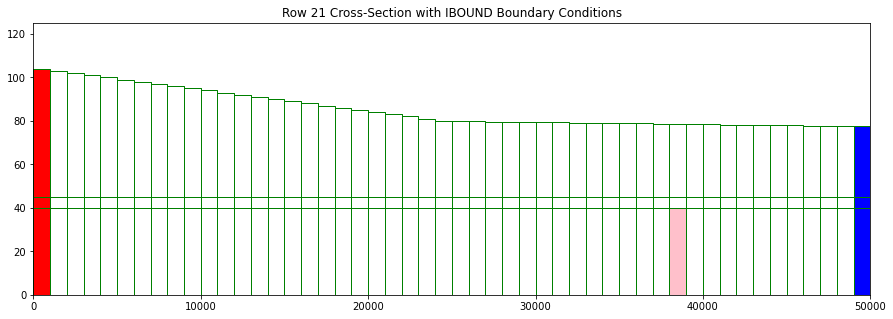

In [7]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m2, line={'row': 21}) #note use the key 'column' if you want to plot a column instead
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
patches = xsect.plot_bc('WEL', color='pink')
linecollection = xsect.plot_grid(color='green')
t = ax.set_title('Row 21 Cross-Section with IBOUND Boundary Conditions')


The plots above show a model profile along row 21. The pink highlight shows the location of the well (the town well was in row 21 and the ag well is in row 12). This one is from YTNA.

# 7. Read in the outputs

### 7.1 Modflow outputs - Heads and budget files

In [8]:
# Head - 1 layer model 
headobj1 = bf.HeadFile(modelname1+'.hds')    #reads the binary head file
times = headobj1.get_times()                 #returns a list of timesteps
head1 = headobj1.get_data(totim=times[-1])   #returns a numpy array of heads for specified time (last timestep)

#Head - 3 layer model 
headobj3 = bf.HeadFile(modelname3+'.hds')    #reads the binary head file
times = headobj3.get_times()                 #returns a list of timesteps
head3 = headobj3.get_data(totim=times[-1])   #returns a numpy array of heads for specified time (last timestep)


#Water balance - 1 layer
budgobj1 = bf.CellBudgetFile(modelname1+'.cbc')   #reads the cell budget file    
print(budgobj1.get_unique_record_names())
kstpkper_list1 = budgobj1.get_kstpkper()          #returns a list of stress periods & timesteps
frf1 = budgobj1.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff1 = budgobj1.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
recharge1 = budgobj1.get_data(text='RECHARGE', totim=1.0) 


#Water balance - 3 layer
budgobj3 = bf.CellBudgetFile(modelname3+'.cbc')   #reads the cell budget file    
print(budgobj3.get_unique_record_names())
kstpkper_list3 = budgobj1.get_kstpkper()          #returns a list of stress periods & timesteps
frf3 = budgobj3.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff3 = budgobj3.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
recharge3 = budgobj3.get_data(text='RECHARGE', totim=1.0) 
print(len(frf3))

[b'   CONSTANT HEAD', b'FLOW RIGHT FACE ', b'FLOW FRONT FACE ', b'FLOW LOWER FACE ', b'              ET', b'        RECHARGE', b'  STREAM LEAKAGE', b'STREAM FLOW OUT ']
[b'   CONSTANT HEAD', b'FLOW RIGHT FACE ', b'FLOW FRONT FACE ', b'FLOW LOWER FACE ', b'              ET', b'        RECHARGE', b'  STREAM LEAKAGE', b'STREAM FLOW OUT ']
1


# 8. Plotting
### 8.1 Cross section plots

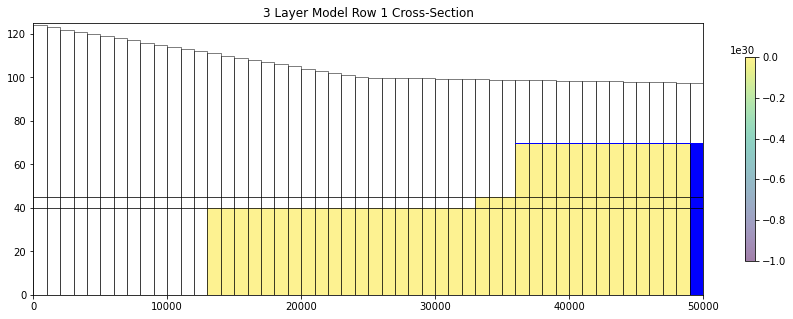

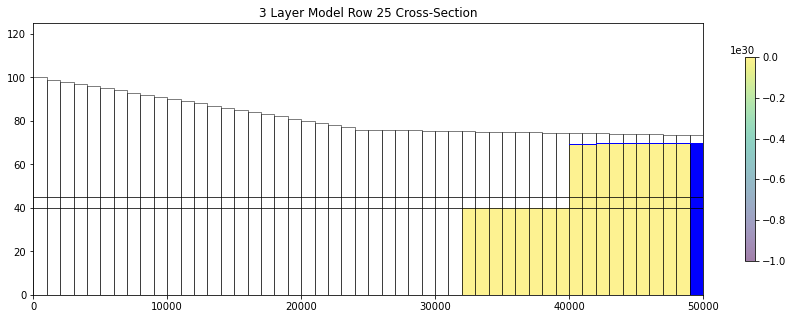

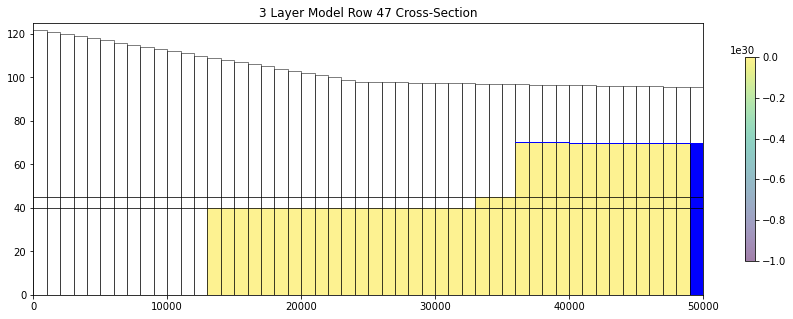

In [9]:
#### 3 layered model 
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m3, line={'row': 1}) #note use the key 'column' if you want to plot a column instaed
pc = xsect.plot_array(head3, masked_values=[999.], head=head3, alpha=0.5)
patches = xsect.plot_ibound(head=head3)
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3 Layer Model Row 1 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head3[0,:,:], masked_values=[999.], color='blue', lw=1)
#plt.savefig("C:/Users/starl/GW_Modelling/homework-starliviakaska/Working/HW10_Layers/CrossSectionLayers4")

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m3, line={'row': 25}) #note use the key 'column' if you want to plot a column instaed
pc = xsect.plot_array(head3, masked_values=[999.], head=head3, alpha=0.5)
patches = xsect.plot_ibound(head=head3)
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3 Layer Model Row 25 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head3[0,:,:], masked_values=[999.], color='blue', lw=1)
#plt.savefig("C:/Users/starl/GW_Modelling/homework-starliviakaska/Working/HW10_Layers/CrossSectionLayers4")

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m3, line={'row': 47}) #note use the key 'column' if you want to plot a column instaed
pc = xsect.plot_array(head3, masked_values=[999.], head=head3, alpha=0.5)
patches = xsect.plot_ibound(head=head3)
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3 Layer Model Row 47 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head3[0,:,:], masked_values=[999.], color='blue', lw=1)
#plt.savefig("C:/Users/starl/GW_Modelling/homework-starliviakaska/Working/HW10_Layers/CrossSectionLayers4")



The plots above are the head profile of different rows in our domain. The location of the head profile is given at the top of the figure. There is one for the top row, the middle, and a row close to the bottom. All of these figures are for YTYA.

### 9.3 3 Layer head contours

C:\Users\starl\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\map.py:819: DeprecationWarning: plot_discharge() has been deprecated and will be replaced in version 3.3.5. Use plot_vector() instead, which should follow after postprocessing.get_specific_discharge()
  warnings.warn(
C:\Users\starl\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\plotutil.py:1630: DeprecationWarning: centered_specific_discharge() has been deprecated and will be removed in version 3.3.5. Use postprocessing.get_specific_discharge() instead.
  warnings.warn(


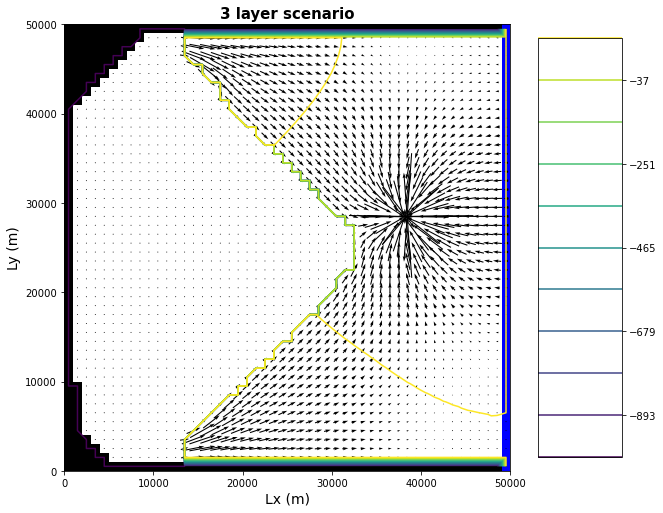

In [10]:
#f, axes = plt.subplots(ncols=1, nrows=2, figsize=(5, 10))
fig3=plt.figure(figsize=(10,10))
# print(fff1[0][0][40])
# print(frf3[0][2][40])

modelmap = flopy.plot.PlotMapView(model=m3, layer=2) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head3[0][0].min(),head3[0][0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head3, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf3[0], fff3[0], head=head3) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('3 layer scenario', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
#plt.show(modelmap)
#plt.savefig("C:/Users/starl/GW_Modelling/homework-starliviakaska/Working/HW10_Layers/FlowContoursThreeLayers4") 

The figure above is for the flow vectors in our domain. This is for YTYA in the top layer. 